In [1]:
__author__ = 'Mike Fitzpatrick <fitz@noao.edu>'
__version__ = '20200925'
__keywords__ = ['spectra','query','vospace','mydb']

# How to use the Spectrum Data Services

### Table of contents
* [Summary](#summary)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#imports)
* [Authentication](#auth)
* [Service URLs and Profiles](#profiles)
* [Dataset Contexts](#contexts)


<a class="anchor" id="summary"></a>
# Summary

This notebook documents how to query, retrieve and visualize spectra from the NOIRLab spectral data service. For full documentation see the <a href="https://datalab.noao.edu/docs/api/specClient.html">API documentation</a>.


### The *specClient* class


The specClient API provides the following interface methods:

          client = getClient (context='<context>', profile='<profile>')

            status = isAlive (svc_url=DEF_SERVICE_URL, timeout=2)

                 set_svc_url (svc_url)
       svc_url = get_svc_url ()

                 set_context (context)
           ctx = get_context ()
        ctxs = list_contexts (optval, token=None, contexts=None, fmt='text')
        ctxs = list_contexts (token=None, contexts=None, fmt='text')

                 set_profile (profile)
          prof = get_profile ()
       profs = list_profiles (optval, token=None, profile=None, fmt='text')
       profs = list_profiles (token=None, profile=None, fmt='text')

             svcs = services (name=None, fmt=None, profile='default')

    QUERY INTERFACE:
             id_list = query (<region> | <coord, size> | <ra, dec, size>,
                              constraint=<sql_where_clause>,
                              context='default', profile='default', **kw)
                             
                              Returns: an array of identifiers mathing the query

    DATA ACCESS INTERFACE:
     spec | [spec] = getSpec (<id> | <id_list>, fmt='numpy',
                              out=None, align=False, cutout=None,
                              context='default', profile='default', **kw)
                             
                              Returns: a spectrum object of the requested type if
                                       given a singe <id>, or an array of those
                                       objects if given an <id_list>

    PLOT  INTERFACE:
                        plot (<id> | <spec>, context=context, profile=profile, **kw)
           status = prospect (spec, context=context, profile=profile, **kw)
         png_image = preview (<id> | <id_list>, context=context, profile=profile, **kw)
        png_image = plotGrid (id_list, nx, ny, page=<N>,
                              context=context, profile=profile, **kw)
    png_image = stackedImage (<id_list>, fmt='png|numpy',
                              align=False, yflip=False,
                              context=context, profile=profile, **kw)

#### Spectrum Identifiers, Contexts and Lists
Spectrum identifiers are specific to the dataset `context`, i.e. SDSS spectra might be uniquely identifiable as a 64-bit 'specobjid' value or as a tuple of (*plate,mjd,fiber,run2d*) values, but other datasets are free to use other types of identifiers peculiar to those data.  An *id* (or an array of *id*, known as an *id_list*) can be any form of integer/tuple/string and is passed transparently to the backend services.  The 'context' parameter can be set explicitly with each call (or globally with the `set_context(<ctx>)` method) and the service will use that information to interpret the idenitfier for the dataset.

When a service such as `getSpec()` is given a single *id* object, it will return a single result of the requested type.  Likewise, if given a list of identifiers, the method will return a list of objects  of the requested type.

#### Input and Output Formats
The result of a `query()` call is always an array of spectrum identifiers which can be passed directly to the 'getSpec()' method to retrieve the data.  If the identifier list is generated in some other way (e.g. a separate query, read from a file, etc) it must be converted to an array first before being used to retrieve data.  The `getSpec()` method will also accept a filename (either local or a virtual storage 'vos://' path) and will read the file assuming there is one identifier per line in the file.
    
Spectra retrieved from 'getSpec()' will be in one of the supported formats and will contain at least the following four bands:
                loglam     the log-lambda wavelength array
                flux       the flux array
                sky        sky spectrum (not supported by all datasets)
                ivar       the inverse variance array

Note these names are specific to the `specCLient` interface and may map to different names in the dataset itself. Additional information may be present depending on the dataset being queried.

#### Saving Results
If no save location is specified (no *out* param) then the results are returned directly. A save location beginning with the 'vos://' identifier indicates a location in the user's virtual storage to save the result. 

### From Python code

[NOTE: Not Yet Implemented as of this writing]

The spectrum client service can be called from Python code using the *datalab* module. This provides methods to access the various query client functions in the *specClient* subpackage. See the information [here](https://github.com/noaodatalab/datalab/blob/master/README.md).

Spectrum commands can be also run from the command line, e.g. on your local machine, using the datalab command line utility. Read about it in our GitHub repo [here](https://github.com/noaodatalab/datalab).


<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noao.edu/disclaimers.php

<a class="anchor" id="imports"></a>

---
# Imports and setup

This is the setup that is required to demonstrate the spectrum services client in this notebook. Whether any particular import is required will depend on your usage.

The first thing to do is import the relevant Python modules.

In [2]:
# Standard libs
from getpass import getpass               # for password prompts

import os
import numpy as np                        # for manipulating arrays
import pandas as pd
from specutils import Spectrum1D

from io import BytesIO
from astropy import units as u
from astropy.visualization import quantity_support
from astropy.coordinates import SkyCoord
from IPython.display import Image, display

from matplotlib import pyplot as plt      # visualization libs
%matplotlib notebook

# Data Lab imports
#from dl import specClient as spc
import specClient as spec                 # if using the specClient.py file directly

from dl import storeClient
from dl import queryClient
from dl import authClient
from dl.helpers.utils import convert

In [3]:
# Global vars for test data
svc_base = "http://datalab.noao.edu/spec"

# Default test single-spectrum
context  = 'sdss_dr16'
specobjid = 2210146812474530816
plate, mjd, fiber, run2d = 1963, 54331, 19, 103
bands    = 'flux,loglam,model,ivar'

# Local laptop test data (15,360 files)
# RUN2D = 103, 22 plates/mjd, 640 fibers each
plates = [1960, 1961, 1962, 1963, 2078, 2079, 2174, 2185, 2247, 2255, 2256, 
          2333, 2338, 2377, 2475, 2476, 2667, 2671, 2800, 2821, 2887, 2912]
mjd = [53289, 53299, 53321, 54331, 53378, 53379, 53521, 53532, 53857,
       54169, 53565, 53859, 53682, 53683, 53991, 53845, 53826, 54142,
       54141, 54326, 54393, 54495, 54521, 54499]
plt_mjd = list(zip(plates,mjd))

<a class="anchor" id="auth"></a>

---
# Authentication
Much of the functionality of spectrum services can be accessed without explicitly logging into Data Lab (the service then uses an anonymous login). But some capabilities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, uncomment the `ac.login()` command and respond according to the prompts.  If you have previously logged into Data Lab, this cell will simply print your active user name.

In [4]:
#authClient.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
authClient.whoAmI()

'fitz'

<a class="anchor" id="profiles"></a>

---
# Service URLs and Profiles

The service URL can be changed when needed, e.g. to point to a development service or a local instance.

In [5]:
# Get the current service URL
svc_url = spec.get_svc_url()
print ('Current ServiceURL:  ' + svc_url)

status = spec.set_svc_url(svc_url)      # Set the ServiceURL

Current ServiceURL:  http://gp06.datalab.noao.edu:6998/spec


Service *profiles* are configuration settings in the service that make use of alternate backends or which provide access to specific data sets.  These may be set in the service interface to apply to all method calls, or can be passed explicitly using 'profile' parameter.

In [6]:
profile = spec.get_profile()         # Get the current profile
print('Current profile: ' + profile)

status = spec.set_profile(profile)   # Reset the current profile
print (spec.list_profiles())         # List the available service profiles

Current profile: default
         default   default
           dldev   DEV Spectrum Service
          dltest   TEST Spectrum Service
       localhost   All-Local Spectrum Service



<a class="anchor" id="contexts"></a>

---
# Dataset Contexts and Catalogs

The initial release of the spectral service include only SDSS DR16 coadded spectra from the BOSS/eBOSS/SDSS surveys.  This is the default *context* for the interface.  As new datasets are added, other contexts will likewise be added that implement the specific details (e.g. storage location, data format, etc) of services for each dataset.

Although not explicitly required, the context can be set for the interface once at the beginning of a sessions and it will apply to all calls unless overridden by an explicit 'context' parameter.  For example,

In [7]:
# Set the interface data context
status = spec.set_context('default')              # use the default (SDSS DR16) context
status = spec.set_context('sdss_dr16')            # same as above

print ('Current context: ' + spec.get_context())  # print the currently active context name

print (spec.list_contexts())                      # print a list of available contexts

Current context: default
         default   Default data context (default: 'sdss_dr16')
       sdss_dr16   SDSS DR16 coadded spectra from BOSS/eBOSS/SDSS



The data context also defines a default catalog to be used by the `query()` method in the interface, however there may be multiple catalogs available within Data Lab that suffice to provide needed identifiers.  The `query()` method contains a 'catalog' parameter that let's you override the default table being queried (e.g. to query a specific Value-Added Catalog), the `catalogs()` method can be used to list available catalogs for a given context:

In [8]:
catalogs = spec.catalogs()
print(catalogs)

Catalogs for 'default' context:

           sdss_dr14.dr14q   SDSS DR14 Quasar Catalog
sdss_dr16.sdssebossfirefly   eBOSS Firefly Value-added Catalog
sdss_dr16.segue1specobjall   SDSS DR14 spectra - Segue-1 survey
sdss_dr16.segue2specobjall   SDSS primary spectra - Segue-2 survey
 sdss_dr16.seguespecobjall   SDSS primary spectra - All Segue survey
         sdss_dr16.specobj   SDSS primary spectra (cleaned table)
      sdss_dr16.specobjall   SDSS primary spectra (may contain duplicates



<a class="anchor" id="query"></a>

---
# Query for Spectra

The first step is to generate a list of spectrum identifiers you wish to retrieve.  The interface provides a `specClient.query()` method to do this using various position-based queries, however the identifier list can just as easily be created by any other query of Data Lab tables.  The only requirement is that an identifier be either a single object (e.g. an integer, tuple, string, etc), or an array of such objects.

### Example 1)  Find spectra in a cone around a specific (RA,Dec) position:

The *query()* method can be called by passing the RA, Dec and a search size (in decimal degrees).  Print the resulting array to the screen by specifying a null *out* parameter.

In [9]:
# RA/Dec query
id_list = spec.query(30.0, 1.0, 0.025, out='')
print (str(id_list))

[1210489508743636992 1750917896554440704 3226968021482366976
 1750920370455603200]


### Example 2)  Find spectra using an Astropy *SkyCoord* object to specify position.  

The *SkyCoord* can be instantiated in a number of ways, however the search size must still be specified in decimal degrees.

In [10]:
# Astropy SkyCoord objects can be created in a number of ways:
posn = [ SkyCoord(ra=30.0*u.degree, dec=1.0*u.degree, frame='icrs'),   # explicit RA,Dec using astropy units
         SkyCoord(ra=30.0, dec=1.0, frame='icrs', unit='deg'),         # explicit RA,Dec position
         SkyCoord('2h0m0.0s +1d0m0s', frame='icrs')                    # sexagesimal position
       ]

for p in posn:
    print(spec.query(p, 0.025))
    print('-------')

[1210489508743636992 1750917896554440704 3226968021482366976
 1750920370455603200]
-------
[1210489508743636992 1750917896554440704 3226968021482366976
 1750920370455603200]
-------
[1210489508743636992 1750917896554440704 3226968021482366976
 1750920370455603200]
-------


### Example 3)  Find spectra within a polygonal region of the sky.

An array containing the vertices of a polygon (specified in decimal degrees) may be use to search for spectra.

In [11]:
# Region query
region = [29.95,0.95, 30.05,0.95, 30.05,1.05, 29.95,1.05]
print(spec.query(region, context='sdss',out=''))

[8822599620880519168 1694626468820183040 8255302463378444288
 1210486485086660608 1210489508743636992 3226968571238180864
 1750919545821882368 1750917896554440704 3226968021482366976
 1750920370455603200 4767234020315779072 1750921744845137920
  789367746562385920 1750921195089324032  453893824498919424]


### Using Alternate Catalogs

The 'catalog' parameter can be used to query alternate catalogs available for a given dataset.  Note that in this example the output identifier list differs from the same positional query used above.  The name of the table to use is *not* limited to those tables listed for the context, any table within Data Lab may be used but we cannot guarantee an identifier will always be correct for the dataset (e.g. earlier SDSS data releases have differing 'specobjid' values). 

In [12]:
# RA/Dec query
id_list = spec.query(30.0, 1.0, 0.025, out='', catalog='sdss_dr16.sdssebossfirefly')
print (str(id_list))

[1210489508743636992 1750917896554440704 2325105415127328768
 3226968021482366976 1750920370455603200]


### Constraining query results

The 'constraint' parameter can be specified as a valid SQL 'where' clause to further constrain the result.  For example, to select above a certain redshift value and sort the results accordingly.  As you can see, the results are different than for the same position used above.  

Note the 'constraint' is appended to the query submitted by the database directly and any quoted values must use single-quotes.

In [13]:
# Constraint tests
print(spec.query(30.0,1.0,0.05, out='',
                 constraint='z > 0.2 order by z'))

[1750919545821882368 4767234020315779072 1750921744845137920
 3226968571238180864  789367746562385920]


### Output Options

In [14]:
# Output option tests

print('######  Output to stdout')
print(spec.query(30.0,1.0,0.025, out=''))      # return output to the caller

######  Output to stdout
[1210489508743636992 1750917896554440704 3226968021482366976
 1750920370455603200]


In [15]:
print('######  Output to local file')
fname = '/tmp/test.id'
if os.path.exists(fname): os.remove(fname)
print(spec.query(30.0,1.0,0.05, out=fname))   # Save result to a local file

if os.path.exists(fname): 
    print('Local file:  SUCCESS')
    os.remove(fname)
else:
    print('Local file:  FAILED')

######  Output to local file
OK
Local file:  SUCCESS


In [16]:
print('######  Output to VOS file')
fname = 'vos://test.id'

if storeClient.access(fname): os.remove(fname)
print(spec.query(30.0,1.0,0.05, out=fname))   # Save results to virtual storage

if storeClient.access(fname): 
    print('VOS file:  SUCCESS')
    storeClient.rm(fname)
else:
    print('VOS file:  FAILED')

######  Output to VOS file
OK
VOS file:  SUCCESS


---
# Retrieving Spectra

Data can be retrieved from the service using the `getSpec()` method.  The only required argument is either a single identifier object, or an array of those objects to return multiple spectra.  When given a single identifier a single spectrum in the requested output format is returned; when given an array of identifiers and array of those objects is returned.  Supported output formats currently include:

                   numpy          A Numpy array
                   pandas         A Pandas DataFrame
                   Spectrum1d     A 'specutils' Spectrum1D object
                   FITS           The original FITS file
                   
Each format contains a 'loglam', 'flux', 'sky', and 'ivar' vector although certain dataset may contain additional information.

The 'align' parameter can be enabled to return all spectra on a common wavelength grid by padding each spectrum as needed to fill the range of wavelengths between the global min/max wavelength of all spectra in the identifier list.  Spectra are *not* interpolated, rather it is assumed for this option that all spectra in the dataset share a common dispersion (usually in log wavelength space).  The 'cutout' parameter can be specified as a wavelength range (e.g. '4500-4750') to return arrays trimmed to that range (the 'align' parameter is implied in this case).  Similarly, the 'bands' parameter can be specified as a command delimited list of bands to return instead of all available data (e.g. bands='loglam,flux' to get just wavelength and flux arrays.

The 'out' parameter can be used to save spectra to a directory (either local or in a virtual space), but is only useful when retrieving FITS files.  In this case, the spectrum file associated with each identified is saved to the named directory.

## Single-Spectrum Access

In [17]:
# Utility routine to print information about a spectrum object.
def info(data):
    try:
        print(' Type: ' + str(type(data)))
        print('  Len: ' + str(len(data)))
        if isinstance(data,list) or isinstance(data,np.ndarray):
            print ('Element Type: ' + str(type(data[0])))
        print('Shape: ' + str(data.shape))
    except Exception as e:
        pass

#### To retrieve a single spectrum, simply pass in a single identifier:

In [18]:
%%time

specobjid = 2210146812474530816      # test spectrum identifier

# Loop over various return formats.
for fmt in ['numpy','pandas', 'Spectrum1D']:
    print('Format: ' + fmt)
    data = spec.getSpec(specobjid, fmt=fmt)
    info(data)
    print('-----------')

Format: numpy
 Type: <class 'list'>
  Len: 1
Element Type: <class 'numpy.ndarray'>
-----------
Format: pandas
 Type: <class 'list'>
  Len: 1
Element Type: <class 'pandas.core.frame.DataFrame'>
-----------
Format: Spectrum1D
 Type: <class 'list'>
  Len: 1
Element Type: <class 'specutils.spectra.spectrum1d.Spectrum1D'>
-----------
CPU times: user 82 ms, sys: 11 ms, total: 93 ms
Wall time: 112 ms


## Multi-Spectrum Query

To retrieve multiple spectra, we need to pass in an *array* of identifiers.  For simplicity, we'll use a `query()` call to generate a list of spectra:

In [19]:
%%time

# Generate a list of spectrum IDs by positional query.
id_list = spec.query(30.0, 1.0, 25.0,
                     ontext='sdss',out='', constraint="z > 0.1 and run2d='26' order by z limit 100")
info(id_list)
print('No. of Spectra: %d' % len(id_list))

 Type: <class 'numpy.ndarray'>
  Len: 100
Element Type: <class 'numpy.uint64'>
Shape: (100,)
No. of Spectra: 100
CPU times: user 29 ms, sys: 2 ms, total: 31 ms
Wall time: 591 ms


To retrieve this list of identifiers, we simply pass it to `getSpec()` to get an array of spectra returned:

In [20]:
%%time 

# Get list by numpy array
#
data = spec.getSpec(id_list, fmt='numpy', align=True)
info(data)

 Type: <class 'list'>
  Len: 100
Element Type: <class 'numpy.ndarray'>
CPU times: user 15 ms, sys: 26 ms, total: 41 ms
Wall time: 296 ms


It is also possible to specify a filename containing identifiers one-per-line.  For example,

In [21]:
%%time 

# Get list by file of IDs
#id_list = spec.query(30.0, 1.0, 25.0,

status = spec.query(30.0, 1.0, 25.0, out='_ids', constraint='limit 100')

data = spec.getSpec('_ids', fmt='numpy', align=True)
info(data)

 Type: <class 'list'>
  Len: 100
Element Type: <class 'numpy.ndarray'>
CPU times: user 43 ms, sys: 20 ms, total: 63 ms
Wall time: 500 ms


---

# Visualization

## Static Spectrum Plot

For single spectra we provide a simple `plot()` method to display the spectrum.  This takes either an identifier (in which case the spectrum is retrieved automatically) or a spectrum object and will display a plot directly which makes is convenient for use in notebooks.  There are a number of options for controlling the plot appearance:

                rest_frame - Whether or not to plot the spectra in the
                             rest-frame  (def: True)
                         z - Redshift value (def: None)
                      xlim - Set the xrange of the plot
                      ylim - Set the yrange of the plot
    
                     bands - A comma-delimited string of which bands to plot,
                             a combination of 'flux,model,sky,ivar'
                mark_lines - Which lines to mark.  No lines marked if None or
                             an empty string, otherwise one of 'em|abs|all|both'
                      grid - Plot grid lines (def: True)
                      dark - Dark-mode plot colors (def: True)
                  em_lines - List of emission lines to plot.  If not given,
                             all the lines in the default list will be plotted.
                 abs_lines - Lines of absorption lines to plot.  If not given,
                             all the lines in the default list will be plotted.
                 spec_args - Plotting kwargs for the spectrum
                model_args - Plotting kwargs for the model
                 ivar_args - Plotting kwargs for the ivar
                  sky_args - Plotting kwargs for the sky

For example, to plot a spectrum from an identifier:

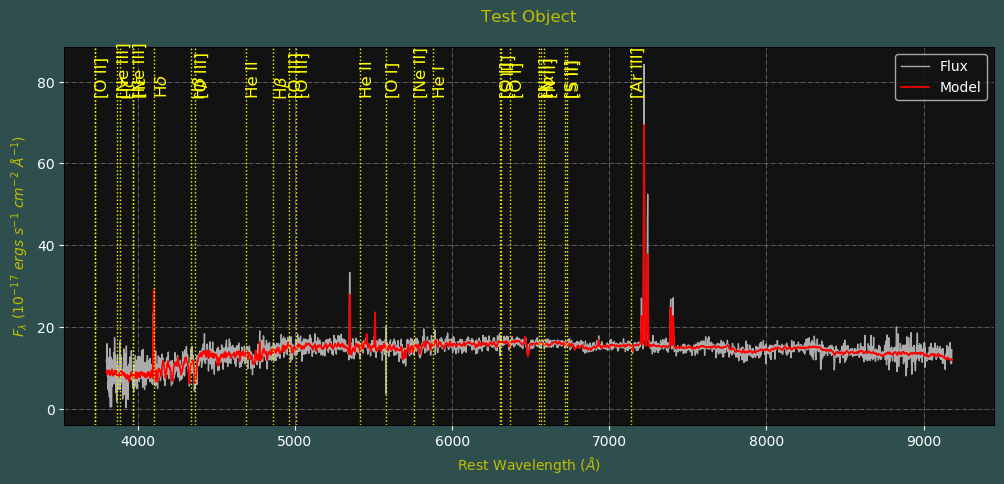

In [22]:
# Use spectrum ID from above query
spec.plot(id_list[4], title='Test Object', figsize=(10,4),bands='flux,model', mark_lines='e')

The above plot uses the 'dark' mode option and marks only the emission lines in the spectrum.  In the next example we plot the data directly, marking both absorption and emission lines:

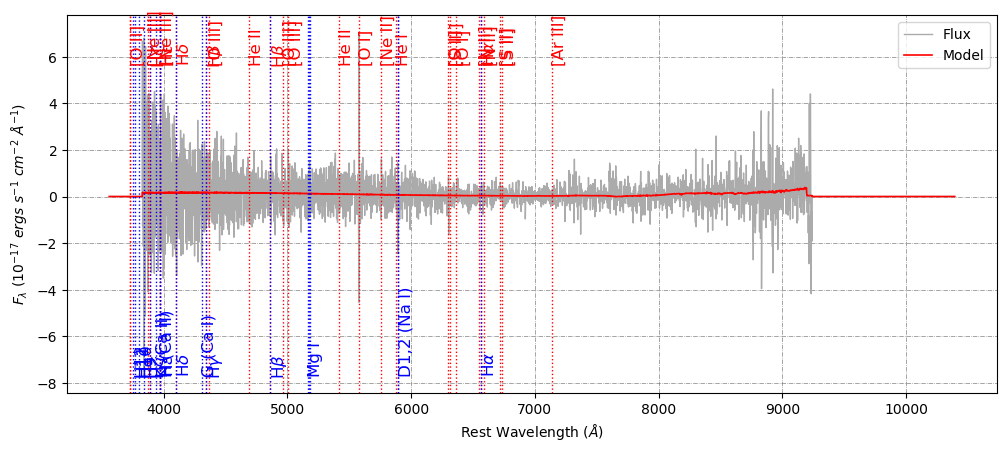

In [23]:
# Plot using retrieved spectrum
spec.plot(data[4], figsize=(10,5), dark=False)

Details of other plotting options can be found in the API documentation [link needed here]

## Preview Plot

Preview images of all spectra have been pre-computed for fast retrieval or use within user interfaces.  The `preview()` method can be used to retrieve a PNG image given a spectrum identifier.

 Type: <class 'PIL.PngImagePlugin.PngImageFile'>
CPU times: user 56 ms, sys: 5 ms, total: 61 ms
Wall time: 60.7 ms


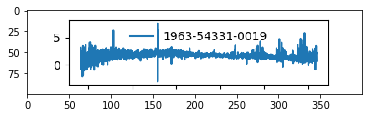

In [24]:
%%time

preview_png = spec.preview(2210146812474530816)
info(preview_png)
plt.imshow(preview_png)

## Grid Preview Plot

Another convenience function is the `plotGrid()` method to retrieve a grid of preview images for a list of spectra.  The user can specify the X and Y dimensions of the grid as well as a 'page' number to paginate the list that may be longer than the grid size.  In this case, the grid is generated on the server and returns a PNG image for display.

 Type: <class 'PIL.PngImagePlugin.PngImageFile'>


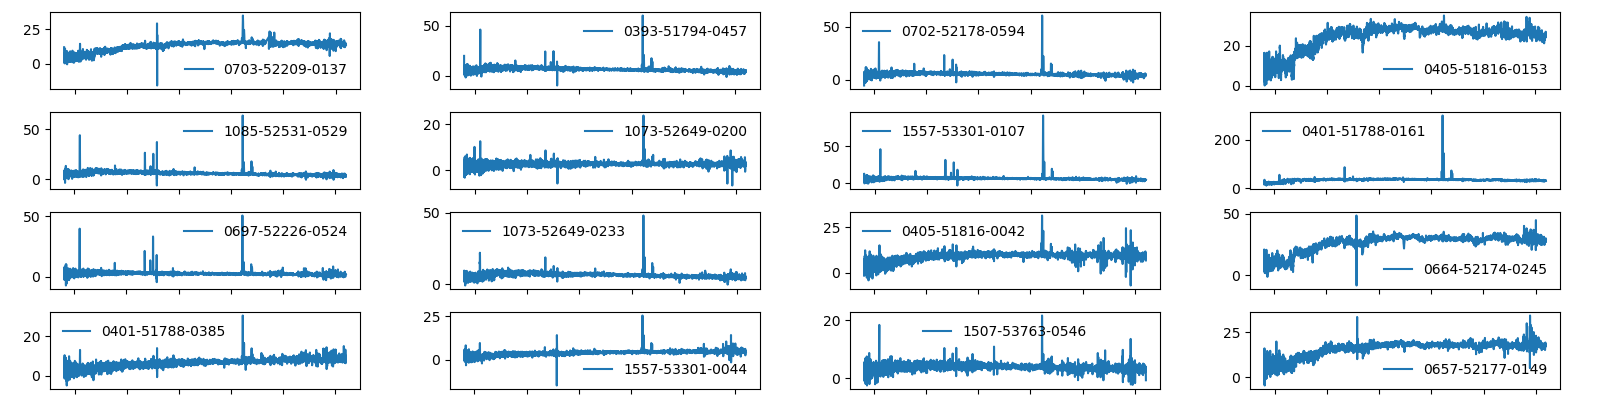

CPU times: user 56 ms, sys: 2 ms, total: 58 ms
Wall time: 113 ms


In [25]:
%%time

grid_png = spec.plotGrid(id_list, 4, 4, page=2, fmt='png')
info(grid_png)
display(grid_png)

Finer control over the display size can be had by using the 'fmt="raw"' option to retrieve the image bytes directly.  This allows the user to specify the display size by creating the image on the client side.

 Type: <class 'bytes'>
  Len: 111964


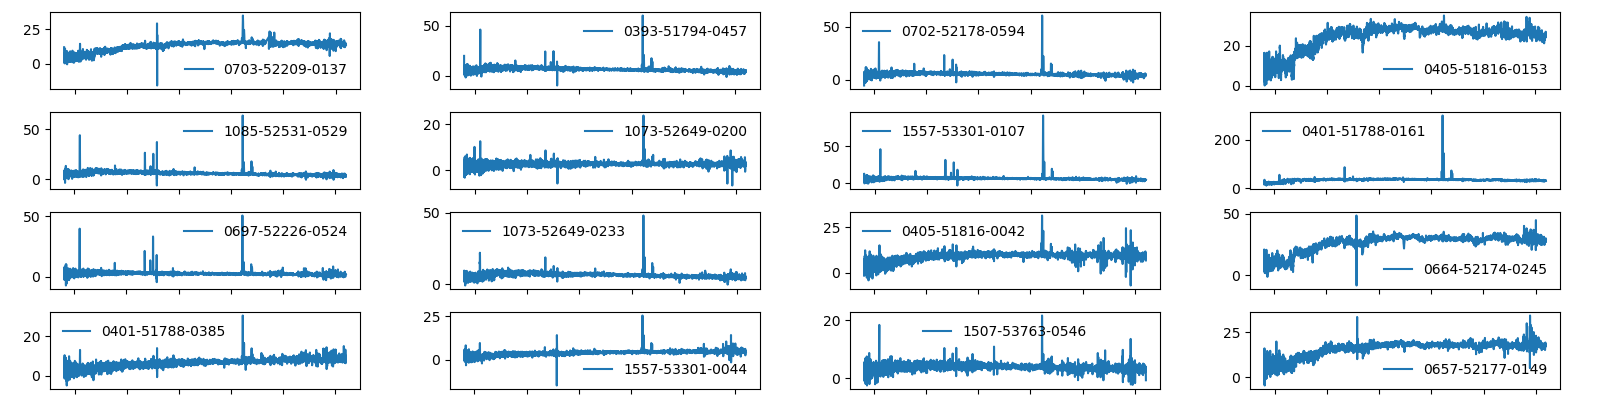

CPU times: user 11 ms, sys: 1 ms, total: 12 ms
Wall time: 64.5 ms


In [26]:
%%time

grid_png = spec.plotGrid(id_list, 4, 4, page=2, fmt='raw')
info(grid_png)
display(Image(grid_png, format='png', width=800, height=800, unconfined=True))

## Stacked Image Plot

A stacked image can be creating by assembling the flux vectors of each spectrum as rows in a 2-D image.  The data will automatically be aligned to a common wavelength grid and padded, meaning that spectral features within an identifier list will line up in the image.  The image is created in the same order as the identifier list allowing a list sorted by e.g. redshift to be displayed using that same sorting method.  The 'scale' parameter can be used to adjust the image size and any matplotlib colormap can be added.

 Type: <class 'PIL.PngImagePlugin.PngImageFile'>


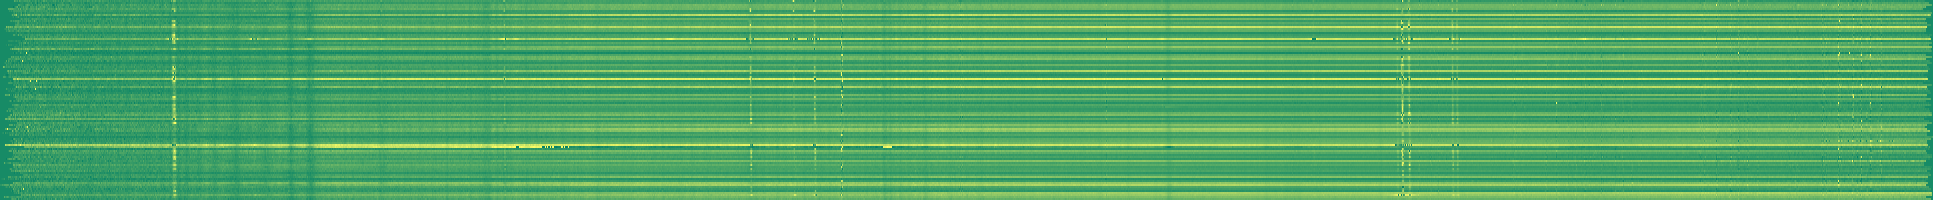

CPU times: user 128 ms, sys: 999 µs, total: 129 ms
Wall time: 400 ms


In [27]:
%%time

stack_png = spec.stackedImage(id_list, scale=(0.5,2.0), cmap='summer', fmt='png')
info(stack_png)
display(stack_png)

Finer control over the display size can be had by using the 'fmt="raw"' option to retrieve the image bytes directly.  This allows the user to specify the display size by creating the image on the client side.

 Type: <class 'bytes'>
  Len: 108306


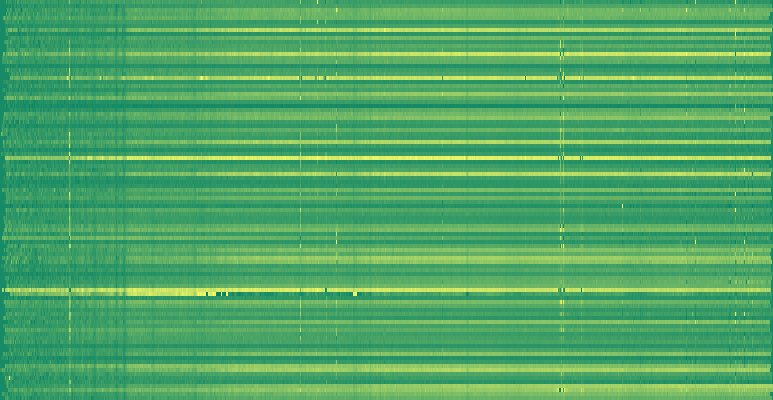

CPU times: user 11 ms, sys: 2 ms, total: 13 ms
Wall time: 221 ms


In [28]:
%%time

stack_png = spec.stackedImage(id_list, scale=(0.2,4.0), cmap='summer', fmt='raw')
info(stack_png)
display(Image(stack_png, format='png', width=800, height=400, unconfined=True))

---

# Utility Methods

### Convert to Spectrum1D 

Given a Numpy array, convert it to a Spectrum1D object:

In [29]:
spec1d = spec.to_Spectrum1D(data[4])
info(spec1d)

 Type: <class 'specutils.spectra.spectrum1d.Spectrum1D'>


### Convert to Pandas DataFrame

Given a Numpy array, convert it to a Pandas DataFrame object:

In [30]:
df = spec.to_pandas(data[4])
info(df)

 Type: <class 'pandas.core.frame.DataFrame'>
  Len: 4655
Shape: (4655, 8)
